# Capstone Project: Malicious URL detection using Machine Learning and Artificial Intelligence


### Model Experiments
#### Explore models hyperparameters

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"
import time
import warnings
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report, accuracy_score,f1_score, precision_score, recall_score, roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
#Collect Initial Data
df4 = pd.read_csv('../data/finaldataset/maliciousurl_processed.csv')

In [3]:
df4.head()

,url,type,category,url_len,domain,root_domain,count_at,count-question,count_hyphen,count_equal,...,count_https,count_http,count_www,digits_count,hostname_length,sus_url,letters_count,short_url,use_of_ip,url_region
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,1310791,0,0,1,0,...,0,0,0,0,0,0,13,0,0,26
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,58335668,0,0,0,0,...,0,0,0,1,0,0,29,0,0,72
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,28611805,0,0,0,0,...,0,0,0,1,0,0,25,0,0,72
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,89045308,0,1,1,4,...,0,1,0,7,17,0,60,0,0,18
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,76838614,0,1,1,3,...,0,1,0,22,23,0,199,0,0,72


In [4]:
df4.shape

(651191, 31)

In [5]:
features = df4.columns[:-1]
print(features)
print('Number of features: {}'.format(len(features)))

Index(['url', 'type', 'category', 'url_len', 'domain', 'root_domain',
       'count_at', 'count-question', 'count_hyphen', 'count_equal',
       'count_dot', 'count_hash', 'count_percent', 'count_plus',
       'count_dollarsign', 'count_exlamation', 'count_star', 'count_comma',
       'count_double_slash', 'count_slash', 'abnormal_url', 'count_https',
       'count_http', 'count_www', 'digits_count', 'hostname_length', 'sus_url',
       'letters_count', 'short_url', 'use_of_ip'],
      dtype='object')
Number of features: 30


###  Train/Test Split

With your data prepared, split it into a train and test set.

In [6]:
X = df4.drop(['url','type','category','domain'],axis=1)
y = df4['category']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Refining selected model 

### Light GBM Classifier

In [8]:
depth_list = []
accuracy_list = []

for depth in range(1,len(X.columns)):
    decision_tree = LGBMClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    accuracy = decision_tree.score(X_test,y_test)
    print('Depth: ',depth, ' Accuracy: ', accuracy)
    accuracy_list.append(decision_tree.score(X_test,y_test))
    depth_list.append(depth)

Depth:  1  Accuracy:  0.8672210321025192
Depth:  2  Accuracy:  0.8879214367432182
Depth:  3  Accuracy:  0.9037001205476086
Depth:  4  Accuracy:  0.913198043596772
Depth:  5  Accuracy:  0.9201391288323774
Depth:  6  Accuracy:  0.9250301369021569
Depth:  7  Accuracy:  0.9276791130153026
Depth:  8  Accuracy:  0.9284776449450626
Depth:  9  Accuracy:  0.928938336443001
Depth:  10  Accuracy:  0.9298366848639809
Depth:  11  Accuracy:  0.9301207779543762
Depth:  12  Accuracy:  0.9307273550933284
Depth:  13  Accuracy:  0.9308655625427099
Depth:  14  Accuracy:  0.9309039535008715
Depth:  15  Accuracy:  0.9309039535008715
Depth:  16  Accuracy:  0.9305968258355792
Depth:  17  Accuracy:  0.9301668471041701
Depth:  18  Accuracy:  0.93076574605149
Depth:  19  Accuracy:  0.9306352167937407
Depth:  20  Accuracy:  0.9308118152012838
Depth:  21  Accuracy:  0.930842527967813
Depth:  22  Accuracy:  0.9303204109368162
Depth:  23  Accuracy:  0.93076574605149
Depth:  24  Accuracy:  0.93076574605149
Depth:  25

In [ ]:
From the above experiment we found Depth=23 will give the best accuracy 

In [10]:
tree_df = pd.DataFrame({'depth': depth_list, 'accuracy' : accuracy_list})

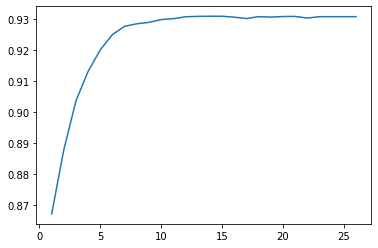

In [11]:

plt.plot(tree_df['depth'], tree_df['accuracy'])
plt.show()

In [22]:
estimator_list = []
accuracy_list = []
#range change based on previous run
for estimator in range(900,1100,50):
    tree = LGBMClassifier(max_depth=24,n_estimators=estimator)
    tree.fit(X_train, y_train)
    accuracy = tree.score(X_test,y_test)
    print('Estimator: ',estimator, ' Accuracy: ', accuracy)
    accuracy_list.append(tree.score(X_test,y_test))
    estimator_list.append(depth)

Estimator:  900  Accuracy:  0.9448705840800374
Estimator:  950  Accuracy:  0.9450395042959482
Estimator:  1000  Accuracy:  0.9452314590867559
Estimator:  1050  Accuracy:  0.9438263500180437


Estimator=1000 will give the best accuracy

In [25]:
from sklearn.model_selection import cross_val_score
tree = LGBMClassifier( n_estimators=1000,max_depth=26,random_state=42)

cv_score = cross_val_score(tree, X_train, y_train, cv=5)
cv_score

array([0.94540795, 0.92461921, 0.94415011, 0.94526346, 0.94664555])

In [26]:

print("Mean: {:.2f}".format(cv_score.mean()))

Mean: 0.94


In [27]:
import sklearn.metrics as metrics
lgb = LGBMClassifier( n_estimators=1000,max_depth=26,random_state=42)
start_time = time.time()
LGB_C = lgb.fit(X_train, y_train)
elapsed_time = time.time() - start_time/ 60  # convert to minutes

y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %s" % score)
print ("%s : %s |Time:%s" %("LGBMClassifier", score,elapsed_time))

              precision    recall  f1-score   support

      benign       0.94      0.98      0.96     85778
  defacement       0.98      1.00      0.99     19104
    phishing       0.98      0.94      0.96      6521
     malware       0.89      0.72      0.80     18836

    accuracy                           0.95    130239
   macro avg       0.95      0.91      0.93    130239
weighted avg       0.94      0.95      0.94    130239

accuracy:   0.9458764271838697
LGBMClassifier : 0.9458764271838697 |Time:1658738849.6651027


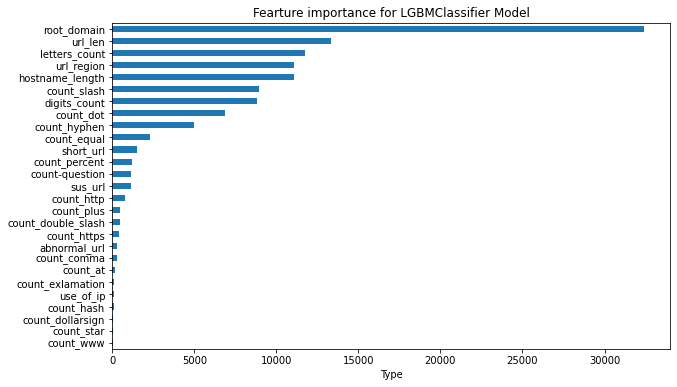

In [30]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6)).set(xlabel='Type',title = 'Fearture importance for LGBMClassifier Model')
plt.savefig("images/fearture-importance-LGBMClassifier-improved")

I got accurancy of 92.994418% for LGBMClassifier in first phase with no parameter, after above experimentation the accurancy was improved to 94.587%. The feature importance increased too.